In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train.csv")

# Exploratory Variable Analysis
* Which variables should we dummify?
* How will we handle missing values?  Do we drop the row, impute using the mean, or other methods?
* Does any of the features look skewed?  Should we transform them using Box-Cox, log, sqrt?
* Quick correlation plots.  Variables with high corrleation to prices should be prioritized as predictors
* How to deal with outliers?
* How to deal with multi-collinearity?

In [3]:
df.shape

(1460, 81)

We have 80 columns (79 predictors, 1 response variable) and 1,459 observations

In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

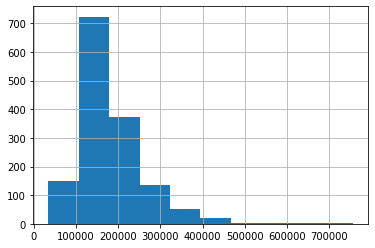

In [5]:
df.SalePrice.hist()

**Observation**
- Target variable SalePrice has a right-skewed distribution, should take a log transform for a linear model.

## Create Custom Features

**LogSalePrice**

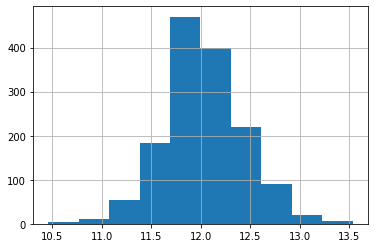

In [6]:
df['LogSalePrice'] = np.log(df['SalePrice'])
df['LogSalePrice'].hist()

After a log transformation, the target variable has a normal distribution. This obeys the assumption of linear regression. 

**Total basement area: AdjTotalBsmtSF** 
 - As a function of finished basement area and unfinished basement area
     - df['AdjTotalBsmtSF']  = df['BsmtFinSF1'] + df['BsmtFinSF2'] + ratio*df['BsmtUnfSF'] 
 - Approach: Select the ratio that has the highest correlation with the target variable LogSalePrice

In [7]:
ratios = np.linspace(0.1,1,10)
corr = []
for ratio in ratios:
    df['AdjTotalBsmtSF']= df['BsmtFinSF1']+ df['BsmtFinSF2']+ ratio*df['BsmtUnfSF']
    corr.append((round(ratio,1),round(df['AdjTotalBsmtSF'].corr(df['LogSalePrice']),4)))
sorted(corr, key = lambda x:x[1],reverse = True)[0]

(0.9, 0.6127)

Using the Optimal ratio of 0.9 to create the custom feature AdjTotalBsmtSF

In [8]:
df['AdjTotalBsmtSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + 0.9*df['BsmtUnfSF']

**Total number of bathrooms: AdjTotalBath**
 - As a function of full bath, half bath above grade and in basement
     - df['AdjTotalBath'] = df['FullBath'] + df['BsmtFullBath'] + ratio*(df['HalfBath'] + df['BsmtHalfBath'])
 - Approach: Select the ratio that has the highest correlation with the target variable LogSalePrice

In [9]:
ratios = np.linspace(0.1,1,10)
corr = []
for ratio in ratios:
    df['AdjTotalBath']= df['FullBath']+ df['BsmtFullBath'] + ratio*(df['HalfBath']+df['BsmtHalfBath'])
    corr.append((round(ratio,1),round(df['AdjTotalBath'].corr(df['LogSalePrice']),4)))

sorted(corr, key = lambda x:x[1],reverse = True)[0]

(0.6, 0.6743)

Using the Optimal ratio of 0.6 to create the custom feature AdjTotalBath

In [10]:
df['AdjTotalBath'] = df['FullBath'] + df['BsmtFullBath'] + 0.6*(df['HalfBath'] + df['BsmtHalfBath'])

**HouseAge**
 - As a function of year of sold, year of built and year of remodel
     - df['HouseAge'] = df['YrSold'] - (ratio* df['YearRemodAdd'] + (1-ratio)*df['YearBuilt'])
 - Approach: Select the ratio that has the highest correlation with the target variable LogSalePrice

In [11]:
ratios = np.linspace(0.1,1,10)
corr = []
for ratio in ratios:
    df['HouseAge'] = df['YrSold'] - (ratio*df['YearRemodAdd'] + (1 - ratio)*df['YearBuilt'])
    corr.append((round(ratio,1),round(df['HouseAge'].corr(df['LogSalePrice']),4)))
sorted(corr, key = lambda x:abs(x[1]),reverse = True)[0]

(0.6, -0.6469)

Using the Optimal ratio of 0.6 to create the custom feature HouseAge

In [12]:
df['HouseAge']= df['YrSold'] - (0.6*df['YearRemodAdd'] + 0.4*df['YearBuilt'])

**Total outdoor area: AdjOutdoorSF**
 - As a sum of all different Porch areas and WoodDeck Area

In [13]:
df['AdjOutdoorSF'] = df['3SsnPorch'] + df['EnclosedPorch'] + df['OpenPorchSF'] + df['ScreenPorch']+ df['WoodDeckSF']
round(df['AdjOutdoorSF'].corr(df['LogSalePrice']),3)

0.398

## Define functions for EDA

In [14]:
def index_of_outliers(df, col_name, stdev_threshold):
    """
    Input Parameters: 
    - df: a dataframe 
    - col_name: the name of the column 
    - stdev_threshold: the standard deviation threshold used to determine outliers 
    
    Returns a list of index that contains outliers defined by the stdev_threshold
    
    """
    mask = np.abs(df[col_name] - df[col_name].mean()) >= (stdev_threshold *df[col_name].std())
    return df.index[mask].tolist()

In [15]:
def EDA_categorical(df, col_name):
    """
    Input Parameters:
    - df: a dataframe
    - col_name: name of the column 
    
    Returns the count of missing values, frequency of each unique value, 
    and a barplot of mean LogSalePrice for each unique value.
    """
    print("Number of missing values: ", df[col_name].isna().sum())
    print("\nUnique values and their frequencies:")
    print(df[col_name].value_counts(sort = True))
    print("\nMean LogSalePrice in different groups of",col_name)
    cat_group = df.groupby(col_name)['LogSalePrice'].mean().sort_values(ascending=False)
    cat_group.plot.bar(x=col_name,y='LogSalePrice')
    plt.xlabel(col_name)
    plt.ylabel('LogSalePrice')
    plt.ylim(min(cat_group.values) - 0.3, max(cat_group.values) + 0.3)

In [16]:
def EDA_numeric(df, col_name):
    """
    Input Parameters:
    - df: a dataframe
    - col_name: name of the column 
    
    Returns the count of missing values, statistic summary, 
    correlations with target variables before and after removing outliers,
    distribution of the column,
    and a scatter plot of LogSalePrice vs the variable. 
    
    """
    print("Number of missing values: ", df[col_name].isna().sum())
    print("\nStatistic summary:")
    print(df[col_name].describe())
    lis = index_of_outliers(df,col_name,stdev_threshold = 4)
    corr_before = df[col_name].corr(df["LogSalePrice"])
    corr_after = df[col_name].drop(lis).corr(df["LogSalePrice"])
    print("\nNumber of outliers that is removed:" + str(len(lis))) 
    print("\nCorrelation with LogSalePrice before and after removing outliers are: %.2f and %.2f, respectively." %(corr_before,corr_after))  
    df[col_name].drop(lis).plot.hist(color = 'green')
    df.drop(lis).plot.scatter( x = col_name, y ='LogSalePrice',color = 'green')

In [17]:
def convert_NA_category(df,col_name):
    """
    Input Parameters:
    - df: a dataframe
    - col_name: name of the column 
    
    The function is used to convert the missing value to a string 'None' 
    and return the modified dataframe. 
    """
    df.loc[df[col_name].isnull(),col_name] = 'None'
    return df

# Variable 1: MSSubClass (Identifies the type of dwelling involved in the sale.)

Number of missing values:  0

Unique values and their frequencies:
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Mean LogSalePrice in different groups of MSSubClass


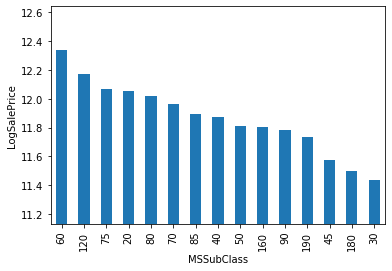

In [18]:
EDA_categorical(df, "MSSubClass")

# Variable 2: MsZoning (Identifies the general zoning classification of the sale.)

Number of missing values:  0

Unique values and their frequencies:
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Mean LogSalePrice in different groups of MSZoning


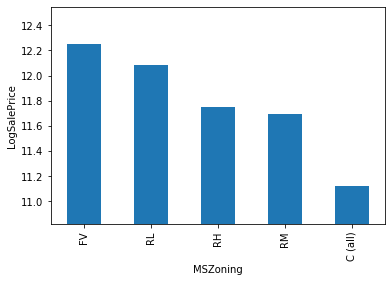

In [19]:
EDA_categorical(df, "MSZoning")

# Variable 3: LotFrontage (Linear feet of street connected to property)

Number of missing values:  259

Statistic summary:
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Number of outliers that is removed:6

Correlation with LogSalePrice before and after removing outliers are: 0.36 and 0.38, respectively.


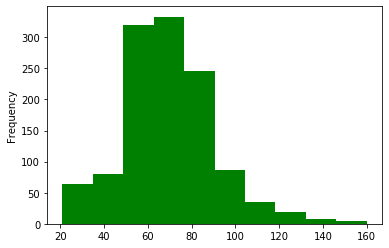

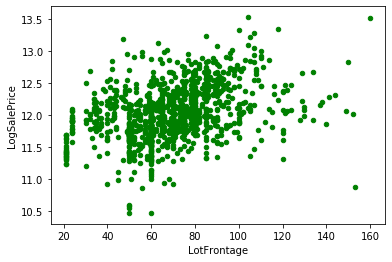

In [20]:
EDA_numeric(df, "LotFrontage")

# Variable 4: LotArea (Lot size in square feet)

Number of missing values:  0

Statistic summary:
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Number of outliers that is removed:10

Correlation with LogSalePrice before and after removing outliers are: 0.26 and 0.38, respectively.


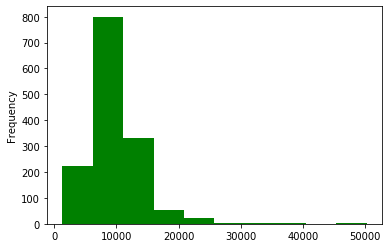

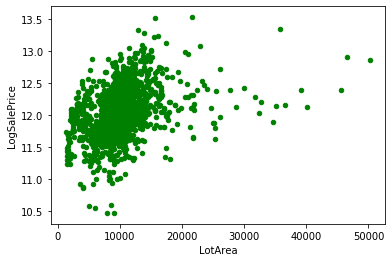

In [21]:
EDA_numeric(df, "LotArea")

# Variable 5: Street (Type of road access to property)

Number of missing values:  0

Unique values and their frequencies:
Pave    1454
Grvl       6
Name: Street, dtype: int64

Mean LogSalePrice in different groups of Street


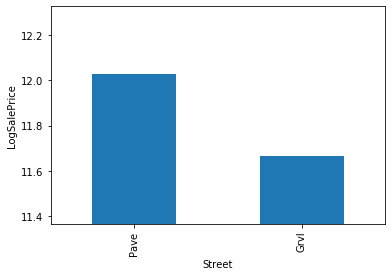

In [23]:
EDA_categorical(df, "Street")

Classes are very unbalanced, should drop this variable in model. 

# Variable 6: Alley (Type of alley access to property)

Number of missing values:  1369

Unique values and their frequencies:
Grvl    50
Pave    41
Name: Alley, dtype: int64

Mean LogSalePrice in different groups of Alley


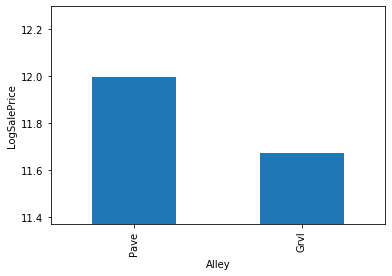

In [25]:
EDA_categorical(df, "Alley")

Lots of missing values, should drop this in the model. 

# Variable 7: LotShape (General shape of property)

Number of missing values:  0

Unique values and their frequencies:
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Mean LogSalePrice in different groups of LotShape


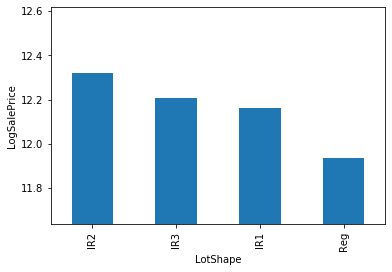

In [27]:
EDA_categorical(df, "LotShape")

# Variable 8: LandContour (Flatness of the property)

Number of missing values:  0

Unique values and their frequencies:
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Mean LogSalePrice in different groups of LandContour


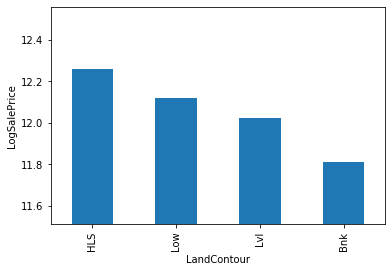

In [29]:
EDA_categorical(df, "LandContour")

# Variable 9: Utilities (Type of utilities available)

Number of missing values:  0

Unique values and their frequencies:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Mean LogSalePrice in different groups of Utilities


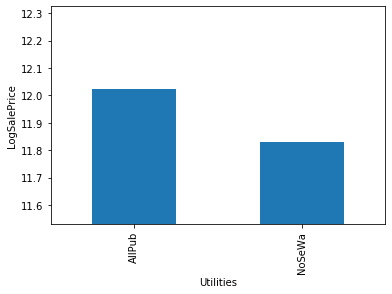

In [31]:
EDA_categorical(df, "Utilities")

Highly unbalanced (only 1 for NoSeWa), should drop this in model. 

# Variable 10: LotConfig (Lot configuration)

Number of missing values:  0

Unique values and their frequencies:
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Mean LogSalePrice in different groups of LotConfig


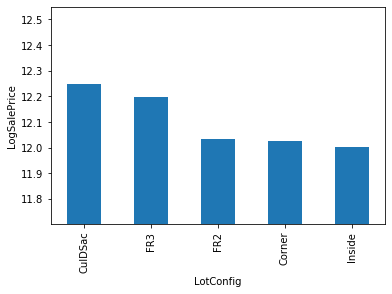

In [33]:
EDA_categorical(df, "LotConfig")

# Variable 11: LandSlope

Number of missing values:  0

Unique values and their frequencies:
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Mean LogSalePrice in different groups of LandSlope


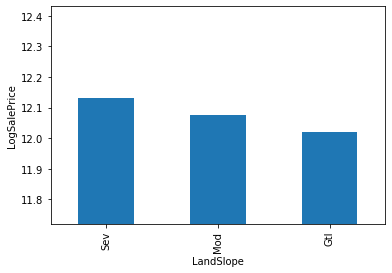

In [36]:
EDA_categorical(df, "LandSlope")

# Variable 12: Neighborhood (Physical locations within Ames city limits)

Number of missing values:  0

Unique values and their frequencies:
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Mean LogSalePrice in different groups of Neighborhood


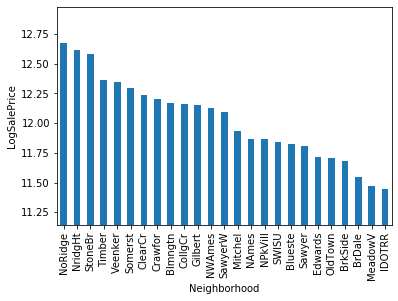

In [37]:
EDA_categorical(df, "Neighborhood")

# Variable 13: Condition1 (Proximity to various conditions)

Number of missing values:  0

Unique values and their frequencies:
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

Mean LogSalePrice in different groups of Condition1


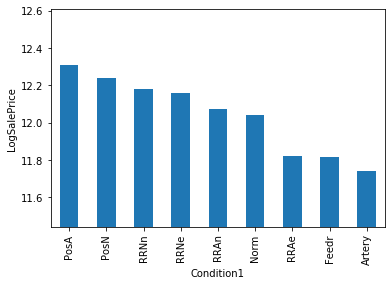

In [39]:
EDA_categorical(df, "Condition1")

# Variable 14: Condition2 (Proximity to various conditions if more than one is present)

Number of missing values:  0

Unique values and their frequencies:
Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAe         1
PosA         1
RRAn         1
Name: Condition2, dtype: int64

Mean LogSalePrice in different groups of Condition2


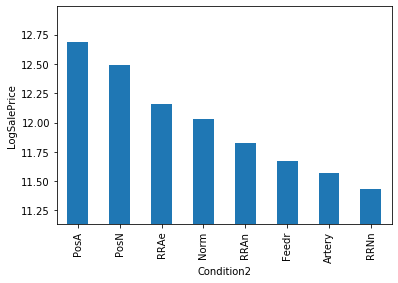

In [41]:
EDA_categorical(df, "Condition2")

# Variable 15: BldgType (Type of dwelling)

Number of missing values:  0

Unique values and their frequencies:
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

Mean LogSalePrice in different groups of BldgType


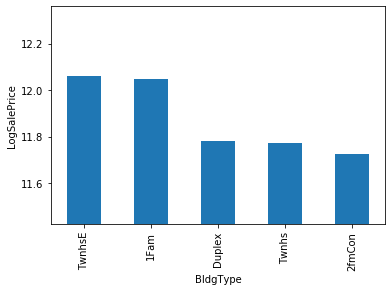

In [43]:
EDA_categorical(df, "BldgType")

# Variable 16: HouseStyle

Number of missing values:  0

Unique values and their frequencies:
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

Mean LogSalePrice in different groups of HouseStyle


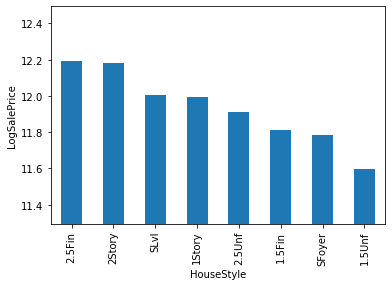

In [45]:
EDA_categorical(df, "HouseStyle")

# Variable 17: OverallQual (Rates the overall material and finish of the house)

Number of missing values:  0

Unique values and their frequencies:
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

Mean LogSalePrice in different groups of OverallQual


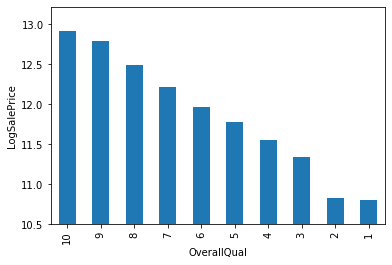

In [144]:
EDA_categorical(df, "OverallQual")

Observe a strong linear relation with the target variable, should keep this variable in the model. 

# Variable 18: OverallCond (Rates the overall condition of the house)

Number of missing values:  0

Unique values and their frequencies:
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

Mean LogSalePrice in different groups of OverallCond


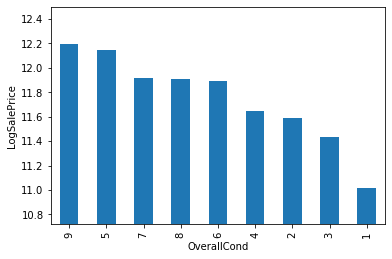

In [143]:
convert_NA_category(df,'OverallCond')
EDA_categorical(df, "OverallCond")

# Variable 19: YearBuilt (Original construction date)

Number of missing values:  0

Statistic summary:
count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

Number of outliers that is removed:0

Correlation with LogSalePrice before and after removing outliers are: 0.59 and 0.59, respectively.


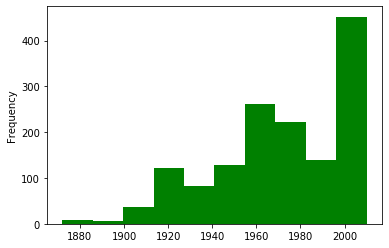

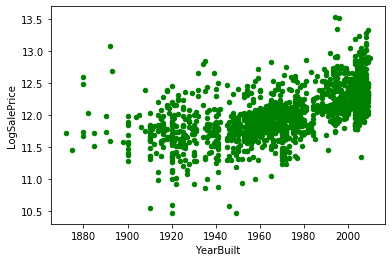

In [146]:
EDA_numeric(df, "YearBuilt")

# Variable 20: YearRemodAdd

Number of missing values:  0

Statistic summary:
count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

Number of outliers that is removed:0

Correlation with LogSalePrice before and after removing outliers are: 0.57 and 0.57, respectively.


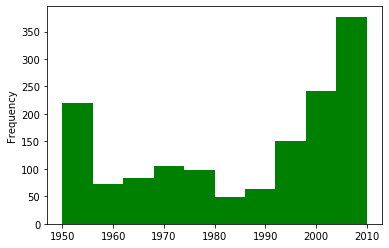

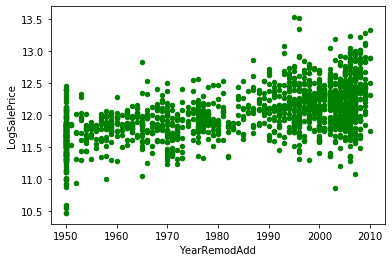

In [54]:
EDA_numeric(df, "YearRemodAdd")

# Variable 21: RoofStyle

Number of missing values:  0

Unique values and their frequencies:
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

Mean LogSalePrice in different groups of RoofStyle


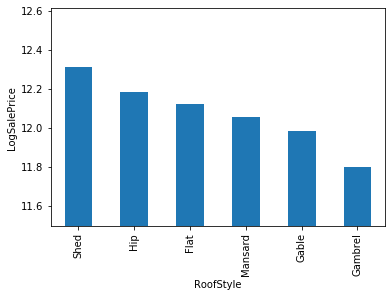

In [57]:
EDA_categorical(df, "RoofStyle")

# Variable 22: RoofMatl

Number of missing values:  0

Unique values and their frequencies:
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
ClyTile       1
Membran       1
Metal         1
Name: RoofMatl, dtype: int64

Mean LogSalePrice in different groups of RoofMatl


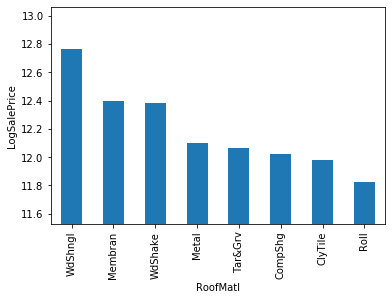

In [59]:
EDA_categorical(df, "RoofMatl")

# Variable 23: Exterior1st

Number of missing values:  0

Unique values and their frequencies:
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

Mean LogSalePrice in different groups of Exterior1st


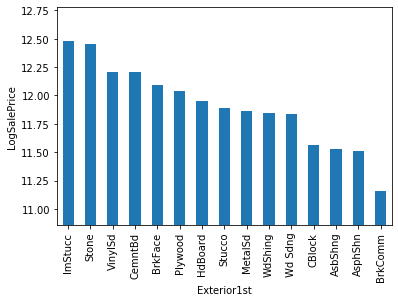

In [61]:
EDA_categorical(df, "Exterior1st")

# Variable 24: Exterior2nd

Number of missing values:  0

Unique values and their frequencies:
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

Mean LogSalePrice in different groups of Exterior2nd


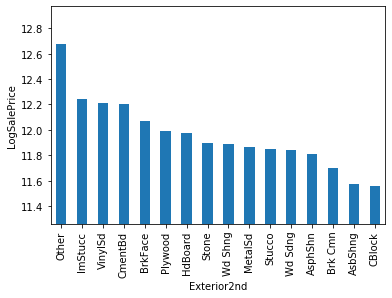

In [62]:
EDA_categorical(df, "Exterior2nd")

# Variable 25: MasVnrType (Masonry veneer type)

Number of missing values:  8

Unique values and their frequencies:
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Mean LogSalePrice in different groups of MasVnrType


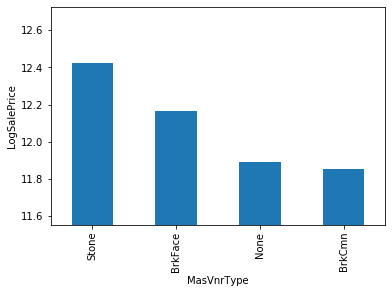

In [64]:
EDA_categorical(df, "MasVnrType")

# Variable 26: MasVnrArea (Masonry veneer area in square feet)

Number of missing values:  8

Statistic summary:
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Number of outliers that is removed:13

Correlation with LogSalePrice before and after removing outliers are: 0.43 and 0.42, respectively.


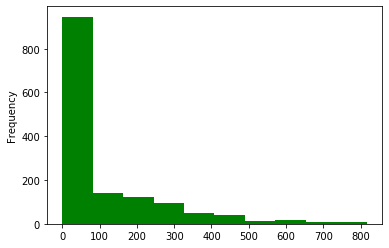

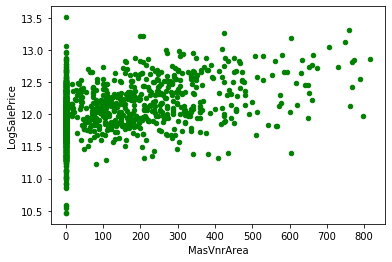

In [65]:
EDA_numeric(df, "MasVnrArea")

# Variable 27: ExterQual

Number of missing values:  0

Unique values and their frequencies:
TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

Mean LogSalePrice in different groups of ExterQual


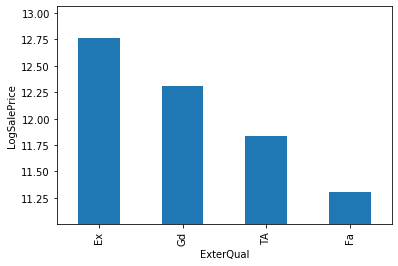

In [68]:
EDA_categorical(df, "ExterQual")

A strong linear relation between ExterQual and LogSalePrice.

# Variable 28: ExterCond

Number of missing values:  0

Unique values and their frequencies:
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

Mean LogSalePrice in different groups of ExterCond


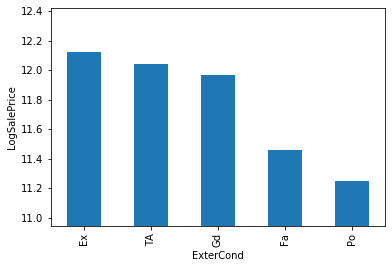

In [70]:
convert_NA_category(df,'ExterCond')
EDA_categorical(df, "ExterCond")

# Variable 29: Foundation

Number of missing values:  0

Unique values and their frequencies:
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

Mean LogSalePrice in different groups of Foundation


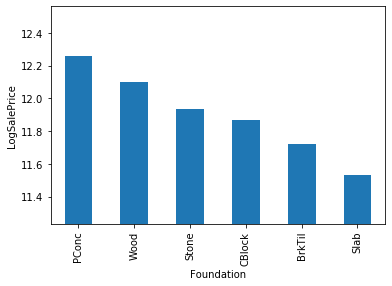

In [72]:
EDA_categorical(df, "Foundation")

# Variable 30: BsmtQual (height of basement)

Number of missing values:  0

Unique values and their frequencies:
TA      649
Gd      618
Ex      121
None     37
Fa       35
Name: BsmtQual, dtype: int64

Mean LogSalePrice in different groups of BsmtQual


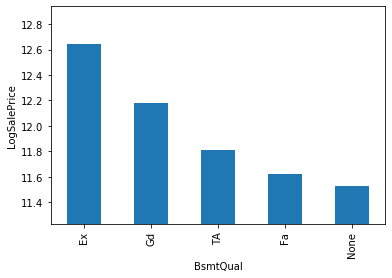

In [74]:
convert_NA_category(df,'BsmtQual')
EDA_categorical(df, "BsmtQual")

# Variable 31: BsmtCond (Evaluates the general condition of the basement)

Number of missing values:  0

Unique values and their frequencies:
TA      1311
Gd        65
Fa        45
None      37
Po         2
Name: BsmtCond, dtype: int64

Mean LogSalePrice in different groups of BsmtCond


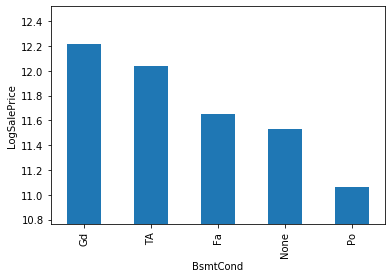

In [76]:
convert_NA_category(df,'BsmtCond')
EDA_categorical(df, "BsmtCond")

# Variable 32: BsmtExposure (Refers to walkout or garden level walls)

Number of missing values:  0

Unique values and their frequencies:
No      953
Av      221
Gd      134
Mn      114
None     38
Name: BsmtExposure, dtype: int64

Mean LogSalePrice in different groups of BsmtExposure


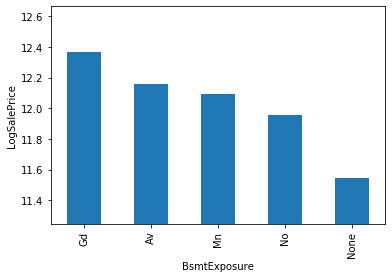

In [78]:
convert_NA_category(df,'BsmtExposure')
EDA_categorical(df, "BsmtExposure")

# Variable 33: BsmtFinType1 (Rating of basement finished area)

Number of missing values:  37

Unique values and their frequencies:
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

Mean LogSalePrice in different groups of BsmtFinType1


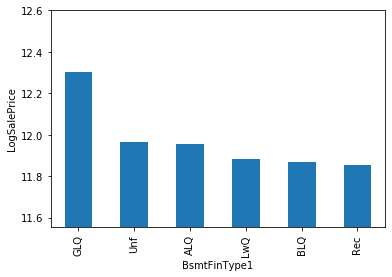

In [80]:
EDA_categorical(df, "BsmtFinType1")

# Variable 34: BsmtFinSF1 (Type 1 finished square feet)

Number of missing values:  0

Statistic summary:
count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

Number of outliers that is removed:1

Correlation with LogSalePrice before and after removing outliers are: 0.37 and 0.39, respectively.


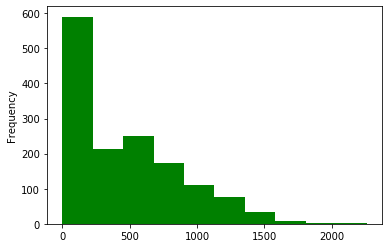

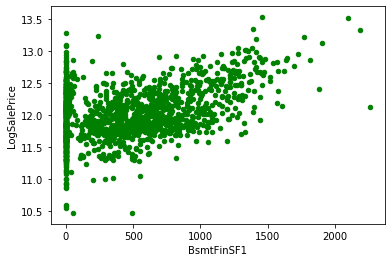

In [82]:
EDA_numeric(df, "BsmtFinSF1")

# Variable 35: BsmtFinType2 (Rating of basement finished area)

Number of missing values:  38

Unique values and their frequencies:
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Mean LogSalePrice in different groups of BsmtFinType2


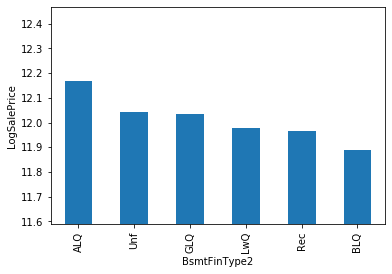

In [84]:
EDA_categorical(df, "BsmtFinType2")

# Variable 36: BsmtFinSF2 (Type 2 finished square feet)

Number of missing values:  0

Statistic summary:
count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

Number of outliers that is removed:25

Correlation with LogSalePrice before and after removing outliers are: 0.00 and -0.05, respectively.


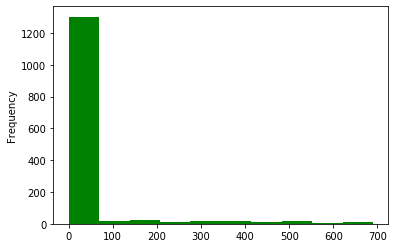

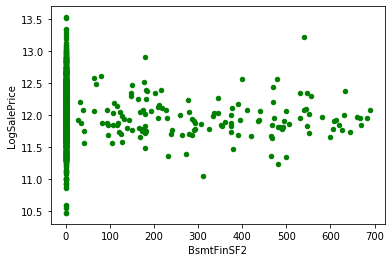

In [86]:
EDA_numeric(df, "BsmtFinSF2")

# Variable 37: BsmtUnfSF (Unfinished square feet of basement area)

Number of missing values:  0

Statistic summary:
count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

Number of outliers that is removed:1

Correlation with LogSalePrice before and after removing outliers are: 0.22 and 0.22, respectively.


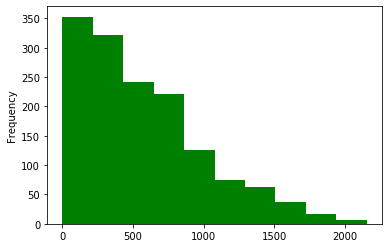

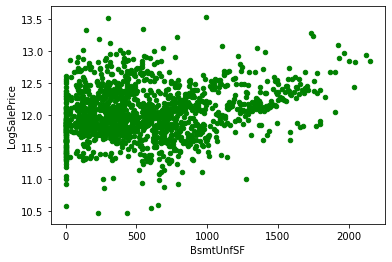

In [88]:
EDA_numeric(df, "BsmtUnfSF")

# Variable 38: TotalBsmtSF (Total square feet of basement area)

Number of missing values:  0

Statistic summary:
count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

Number of outliers that is removed:5

Correlation with LogSalePrice before and after removing outliers are: 0.61 and 0.65, respectively.


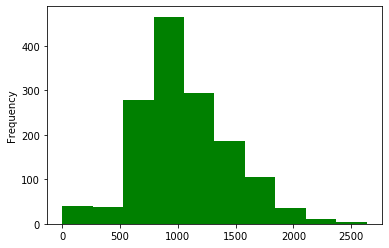

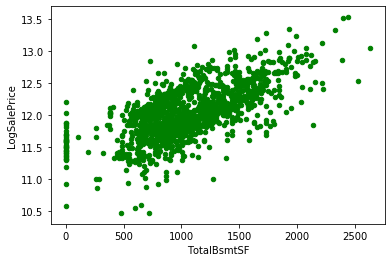

In [90]:
EDA_numeric(df, "TotalBsmtSF")

# Variable 39: Heating (Type of heating)

Number of missing values:  0

Unique values and their frequencies:
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

Mean LogSalePrice in different groups of Heating


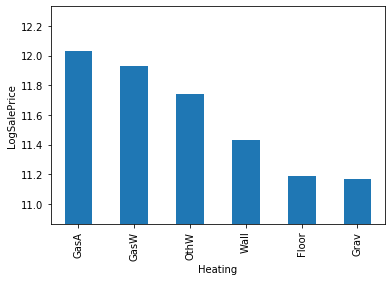

In [92]:
EDA_categorical(df, "Heating")

# Variable 40: HeatingQC (Heating quality and condition)

Number of missing values:  0

Unique values and their frequencies:
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

Mean LogSalePrice in different groups of HeatingQC


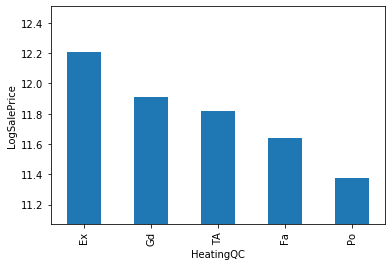

In [94]:
EDA_categorical(df, "HeatingQC")

# Variable 41: CentralAir

Number of missing values:  0

Unique values and their frequencies:
Y    1365
N      95
Name: CentralAir, dtype: int64

Mean LogSalePrice in different groups of CentralAir


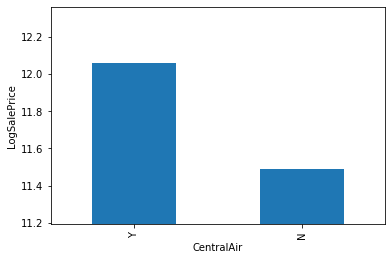

In [96]:
EDA_categorical(df, "CentralAir")

# Variable 42: Electrical

Number of missing values:  1

Unique values and their frequencies:
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Mean LogSalePrice in different groups of Electrical


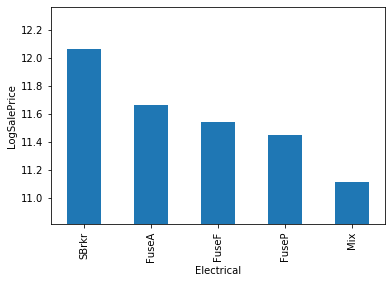

In [97]:
EDA_categorical(df, "Electrical")

# Variable 43: 1stFlrSF

Number of missing values:  0

Statistic summary:
count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

Number of outliers that is removed:4

Correlation with LogSalePrice before and after removing outliers are: 0.60 and 0.62, respectively.


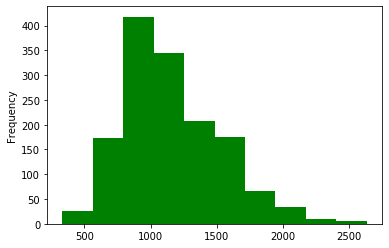

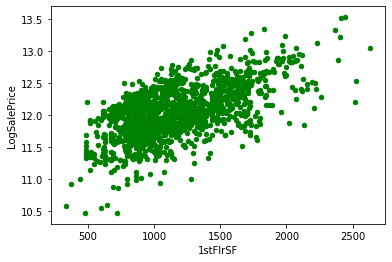

In [98]:
EDA_numeric(df, "1stFlrSF")

Strong linear correlation.

# Variable 44: 2ndFlrSF

Number of missing values:  0

Statistic summary:
count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

Number of outliers that is removed:0

Correlation with LogSalePrice before and after removing outliers are: 0.32 and 0.32, respectively.


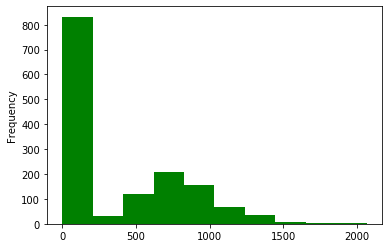

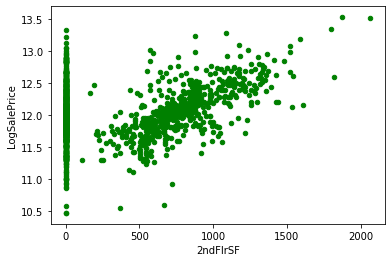

In [99]:
EDA_numeric(df, "2ndFlrSF")

# Variable 45: LowQualFinSF

Number of missing values:  0

Statistic summary:
count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

Number of outliers that is removed:19

Correlation with LogSalePrice before and after removing outliers are: -0.04 and -0.05, respectively.


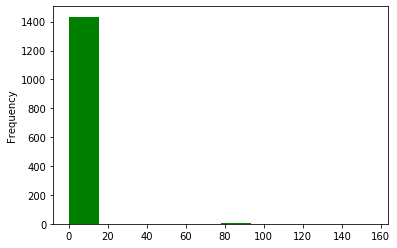

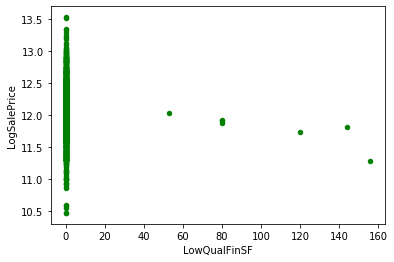

In [100]:
EDA_numeric(df, "LowQualFinSF")

# Variable 46: GrLivArea

Number of missing values:  0

Statistic summary:
count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

Number of outliers that is removed:5

Correlation with LogSalePrice before and after removing outliers are: 0.70 and 0.72, respectively.


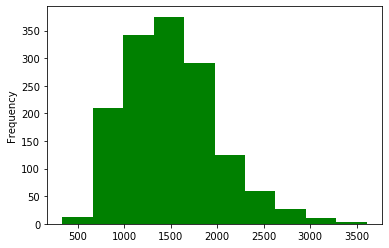

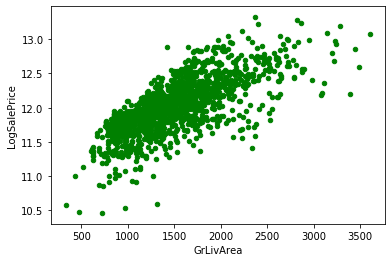

In [147]:
EDA_numeric(df, "GrLivArea")

Strong linear correlation.

# Variable 47: BsmtFullBath

Number of missing values:  0

Unique values and their frequencies:
0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

Mean LogSalePrice in different groups of BsmtFullBath


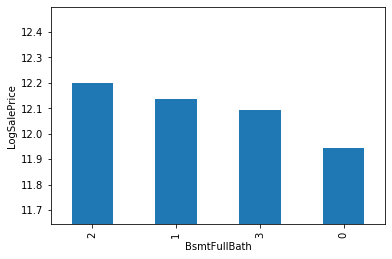

In [148]:
EDA_categorical(df, "BsmtFullBath")

# Variable 48: BsmtHalfBath

Number of missing values:  0

Unique values and their frequencies:
0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

Mean LogSalePrice in different groups of BsmtHalfBath


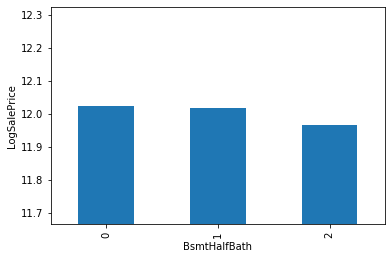

In [149]:
EDA_categorical(df, "BsmtHalfBath")

# Variable 49: FullBath

Number of missing values:  0

Unique values and their frequencies:
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

Mean LogSalePrice in different groups of FullBath


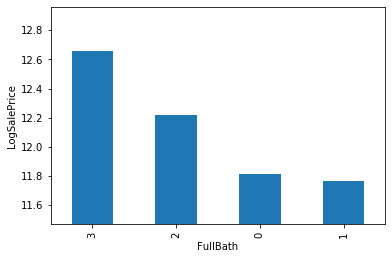

In [150]:
EDA_categorical(df, "FullBath")

# Variable 50: HalfBath

Number of missing values:  0

Unique values and their frequencies:
0    913
1    535
2     12
Name: HalfBath, dtype: int64

Mean LogSalePrice in different groups of HalfBath


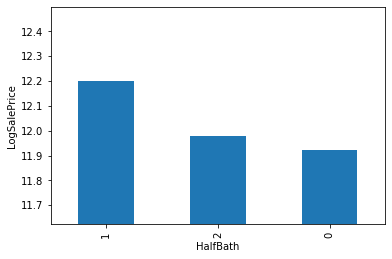

In [151]:
EDA_categorical(df, "HalfBath")

# Variable 51: BedroomAbvGr

Number of missing values:  0

Unique values and their frequencies:
3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

Mean LogSalePrice in different groups of BedroomAbvGr


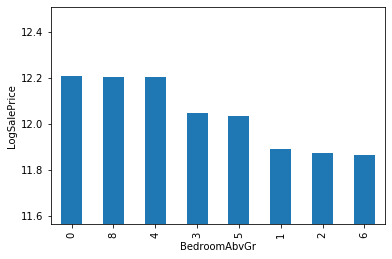

In [152]:
EDA_categorical(df, "BedroomAbvGr")

# Variable 52: KitchenAbvGr

Number of missing values:  0

Unique values and their frequencies:
1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

Mean LogSalePrice in different groups of KitchenAbvGr


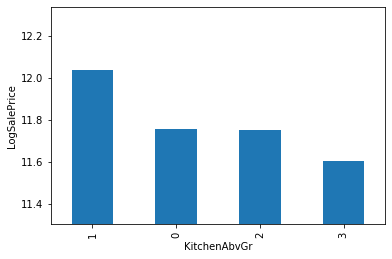

In [153]:
EDA_categorical(df, "KitchenAbvGr")

# Variable 53: KitchenQual

Number of missing values:  0

Unique values and their frequencies:
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

Mean LogSalePrice in different groups of KitchenQual


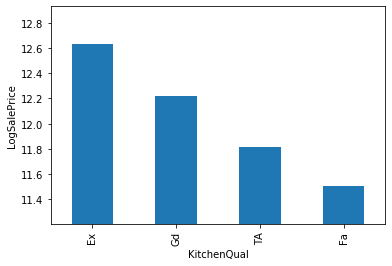

In [108]:
EDA_categorical(df, "KitchenQual")

# Variable 54: TotRmsAbvGrd

Number of missing values:  0

Unique values and their frequencies:
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

Mean LogSalePrice in different groups of TotRmsAbvGrd


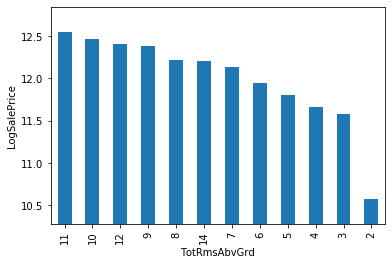

In [154]:
EDA_categorical(df, "TotRmsAbvGrd")

# Variable 55: Functional

Number of missing values:  0

Unique values and their frequencies:
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

Mean LogSalePrice in different groups of Functional


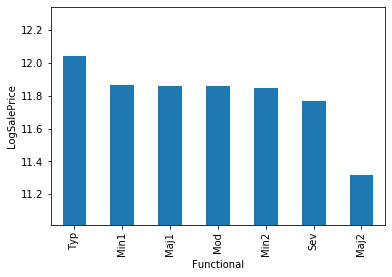

In [111]:
EDA_categorical(df, "Functional")

# Variable 56: Fireplaces

Number of missing values:  0

Unique values and their frequencies:
0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

Mean LogSalePrice in different groups of Fireplaces


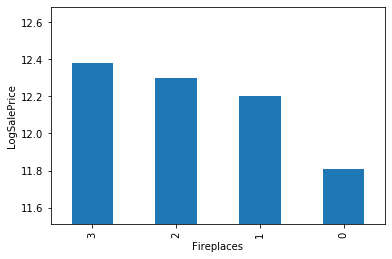

In [155]:
EDA_categorical(df, "Fireplaces")

# Variable 57: FireplaceQu

Number of missing values:  0

Unique values and their frequencies:
None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64

Mean LogSalePrice in different groups of FireplaceQu


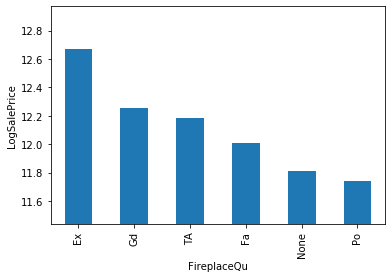

In [113]:
convert_NA_category(df,'FireplaceQu')
EDA_categorical(df, "FireplaceQu")

# Variable 58: GarageType

Number of missing values:  81

Unique values and their frequencies:
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Mean LogSalePrice in different groups of GarageType


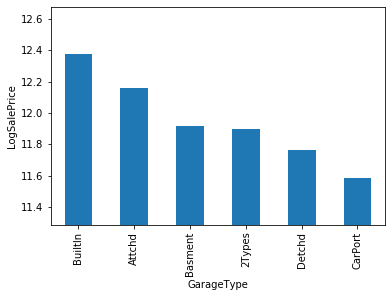

In [114]:
EDA_categorical(df, "GarageType")

# Variable 59: GarageYrBlt

Number of missing values:  81

Statistic summary:
count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

Number of outliers that is removed:0

Correlation with LogSalePrice before and after removing outliers are: 0.54 and 0.54, respectively.


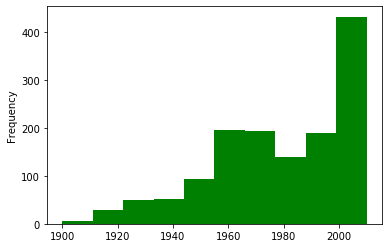

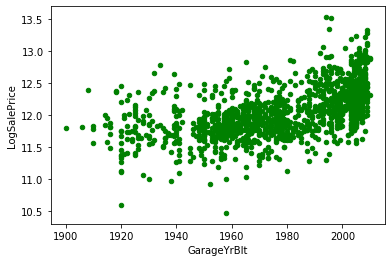

In [158]:
EDA_numeric(df, "GarageYrBlt")

# Variable 60: GarageFinish

Number of missing values:  81

Unique values and their frequencies:
Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

Mean LogSalePrice in different groups of GarageFinish


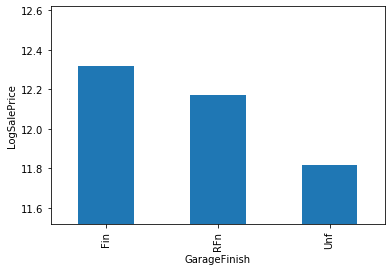

In [116]:
EDA_categorical(df, "GarageFinish")

# Variable 61: GarageCars

Number of missing values:  0

Unique values and their frequencies:
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

Mean LogSalePrice in different groups of GarageCars


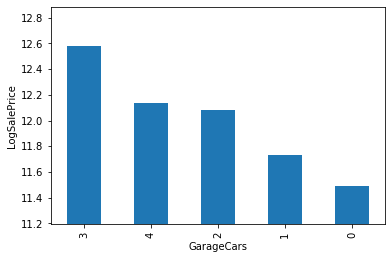

In [159]:
EDA_categorical(df, "GarageCars")

# Variable 62: GarageArea

Number of missing values:  0

Statistic summary:
count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

Number of outliers that is removed:3

Correlation with LogSalePrice before and after removing outliers are: 0.65 and 0.66, respectively.


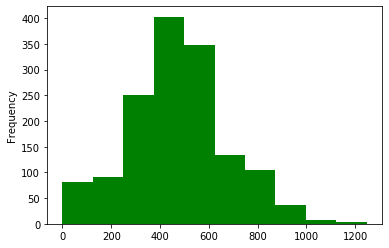

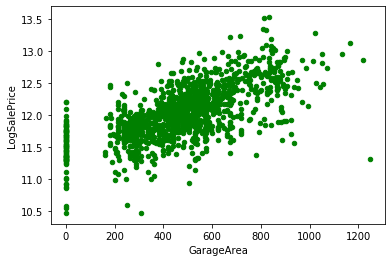

In [119]:
EDA_numeric(df, "GarageArea")

# Variable 63: GarageQual

Number of missing values:  0

Unique values and their frequencies:
TA      1311
None      81
Fa        48
Gd        14
Ex         3
Po         3
Name: GarageQual, dtype: int64

Mean LogSalePrice in different groups of GarageQual


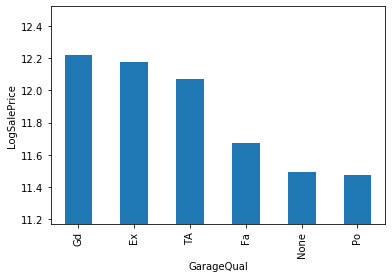

In [120]:
convert_NA_category(df,'GarageQual')
EDA_categorical(df, "GarageQual")

# Variable 64: GarageCond

Number of missing values:  0

Unique values and their frequencies:
TA      1326
None      81
Fa        35
Gd         9
Po         7
Ex         2
Name: GarageCond, dtype: int64

Mean LogSalePrice in different groups of GarageCond


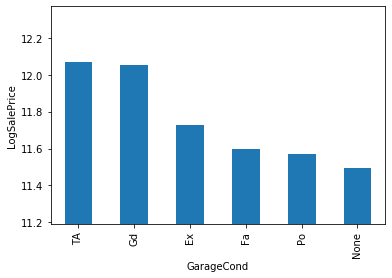

In [121]:
convert_NA_category(df,"GarageCond")
EDA_categorical(df, "GarageCond")

# Variable 65: PavedDrive

Number of missing values:  0

Unique values and their frequencies:
Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

Mean LogSalePrice in different groups of PavedDrive


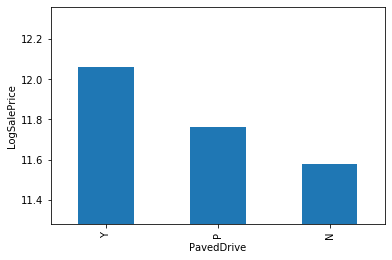

In [122]:
EDA_categorical(df, "PavedDrive")

# Variable 66: WoodDeckSF

Number of missing values:  0

Statistic summary:
count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

Number of outliers that is removed:6

Correlation with LogSalePrice before and after removing outliers are: 0.33 and 0.34, respectively.


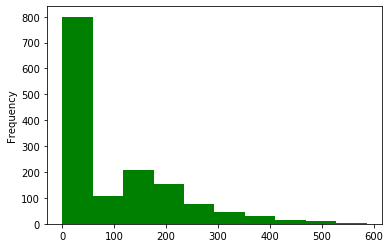

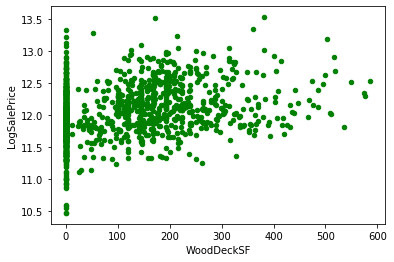

In [123]:
EDA_numeric(df, "WoodDeckSF")

# Variable 67: OpenPorchSF

Number of missing values:  0

Statistic summary:
count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

Number of outliers that is removed:10

Correlation with LogSalePrice before and after removing outliers are: 0.32 and 0.37, respectively.


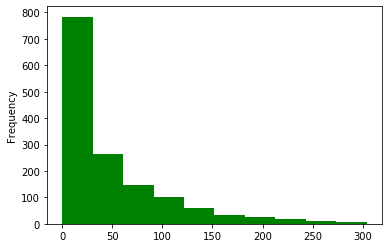

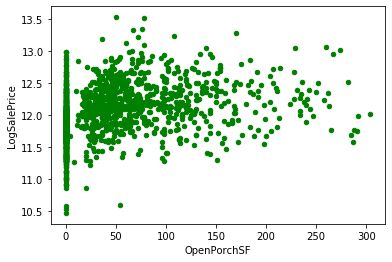

In [124]:
EDA_numeric(df, "OpenPorchSF")

# Variable 68: EnclosedPorch

Number of missing values:  0

Statistic summary:
count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

Number of outliers that is removed:13

Correlation with LogSalePrice before and after removing outliers are: -0.15 and -0.18, respectively.


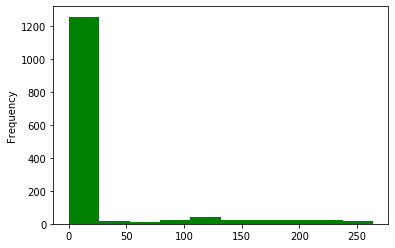

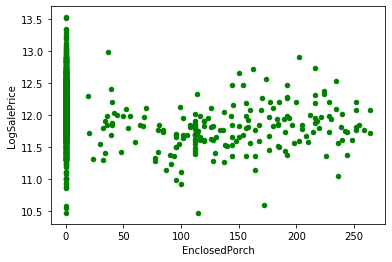

In [125]:
EDA_numeric(df, "EnclosedPorch")

# Variable 69: 3SsnPorch

Number of missing values:  0

Statistic summary:
count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

Number of outliers that is removed:22

Correlation with LogSalePrice before and after removing outliers are: 0.05 and 0.01, respectively.


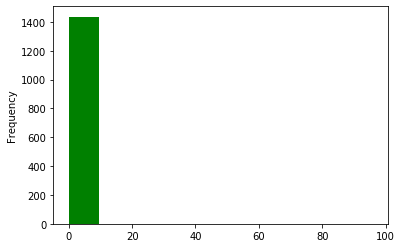

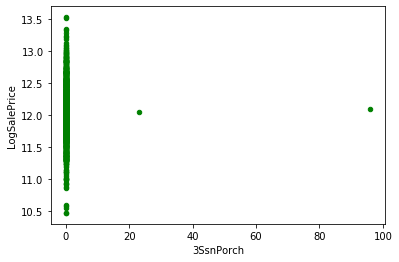

In [126]:
EDA_numeric(df, "3SsnPorch")

# Variable 70: ScreenPorch

Number of missing values:  0

Statistic summary:
count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

Number of outliers that is removed:22

Correlation with LogSalePrice before and after removing outliers are: 0.12 and 0.10, respectively.


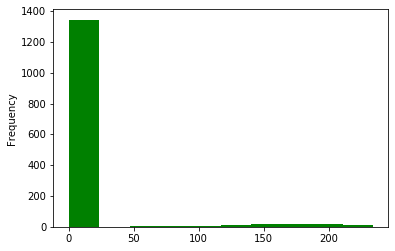

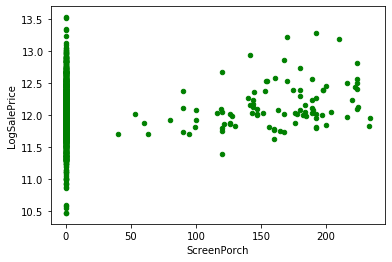

In [127]:
EDA_numeric(df, "ScreenPorch")

# Variable 71: PoolArea

Number of missing values:  0

Statistic summary:
count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

Number of outliers that is removed:7

Correlation with LogSalePrice before and after removing outliers are: 0.07 and nan, respectively.


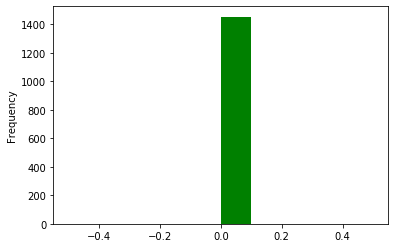

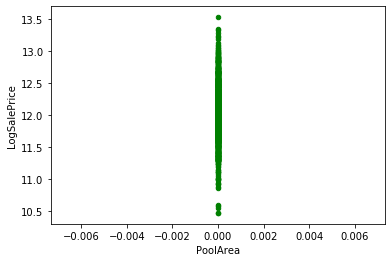

In [128]:
EDA_numeric(df, "PoolArea")

Majority of houses do not have a pool. 

# Variable 72: PoolQC

Number of missing values:  1453

Unique values and their frequencies:
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

Mean LogSalePrice in different groups of PoolQC


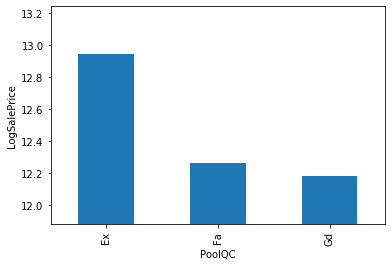

In [129]:
EDA_categorical(df, "PoolQC")

# Variable 73: Fence

Number of missing values:  1179

Unique values and their frequencies:
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Mean LogSalePrice in different groups of Fence


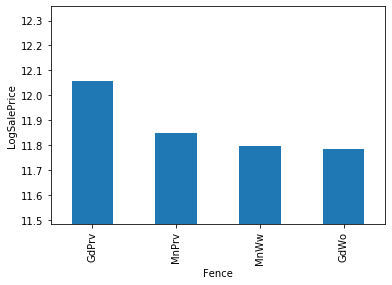

In [130]:
EDA_categorical(df, "Fence")

# Variable 74: MiscFeature

Number of missing values:  1406

Unique values and their frequencies:
Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

Mean LogSalePrice in different groups of MiscFeature


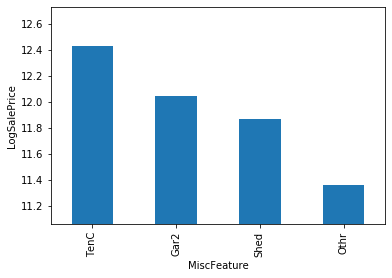

In [131]:
EDA_categorical(df, "MiscFeature")

# Variable 75: MiscVal

Number of missing values:  0

Statistic summary:
count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

Number of outliers that is removed:4

Correlation with LogSalePrice before and after removing outliers are: -0.02 and -0.03, respectively.


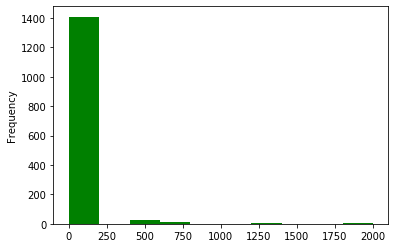

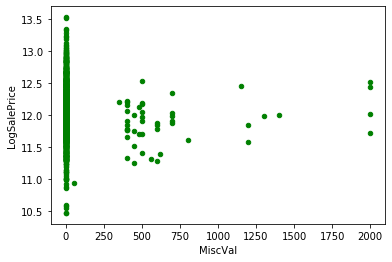

In [132]:
EDA_numeric(df, "MiscVal")

# Variable 76: MoSold

Number of missing values:  0

Unique values and their frequencies:
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

Mean LogSalePrice in different groups of MoSold


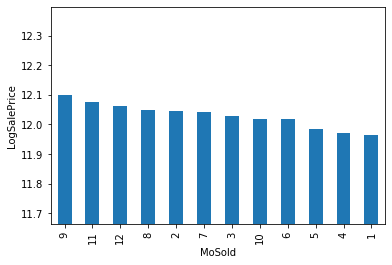

In [133]:
EDA_categorical(df, "MoSold")

# Variable 77: YrSold

Number of missing values:  0

Unique values and their frequencies:
2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

Mean LogSalePrice in different groups of YrSold


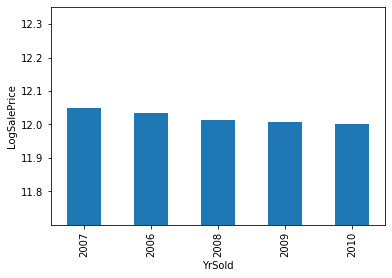

In [134]:
EDA_categorical(df, "YrSold")

# Variable 78: SaleType

Number of missing values:  0

Unique values and their frequencies:
WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

Mean LogSalePrice in different groups of SaleType


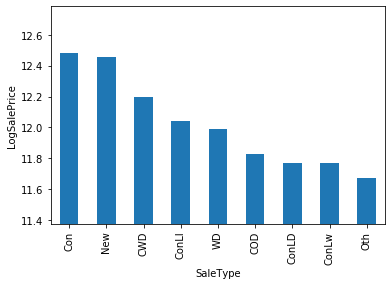

In [135]:
EDA_categorical(df, "SaleType")

# Variable 79: SaleCondition

Number of missing values:  0

Unique values and their frequencies:
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

Mean LogSalePrice in different groups of SaleCondition


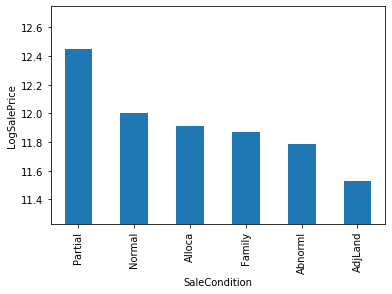

In [136]:
EDA_categorical(df, "SaleCondition")

# Variable 80: SalePrice

Number of missing values:  0

Statistic summary:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Number of outliers that is removed:9

Correlation with LogSalePrice before and after removing outliers are: 0.95 and 0.96, respectively.


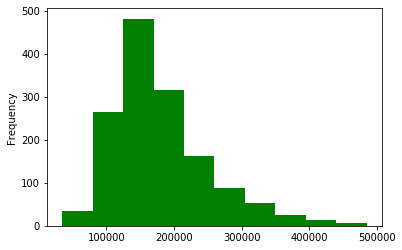

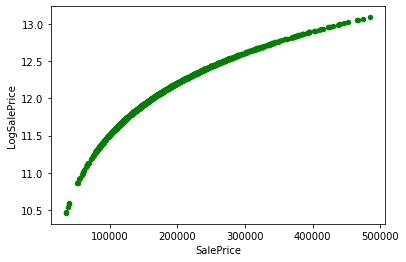

In [137]:
EDA_numeric(df, "SalePrice")

# Variable 81: HouseAge

Number of missing values:  0

Statistic summary:
count    1460.000000
mean       28.389178
std        21.860175
min        -0.600000
25%         7.000000
50%        28.900000
75%        44.250000
max        86.000000
Name: HouseAge, dtype: float64

Number of outliers that is removed:0

Correlation with LogSalePrice before and after removing outliers are: -0.65 and -0.65, respectively.


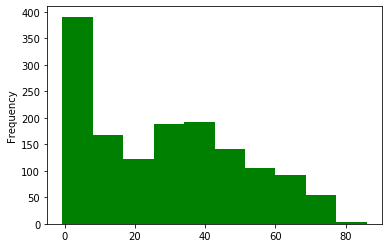

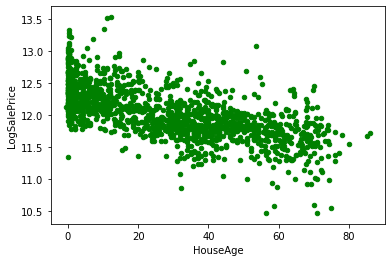

In [138]:
EDA_numeric(df, "HouseAge")

# Variable 82 AdjTotalBsmtSF

Number of missing values:  0

Statistic summary:
count    1460.000000
mean     1000.705411
std       422.269327
min         0.000000
25%       747.150000
50%       941.100000
75%      1231.200000
max      6063.400000
Name: AdjTotalBsmtSF, dtype: float64

Number of outliers that is removed:5

Correlation with LogSalePrice before and after removing outliers are: 0.61 and 0.65, respectively.


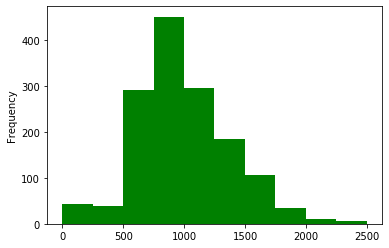

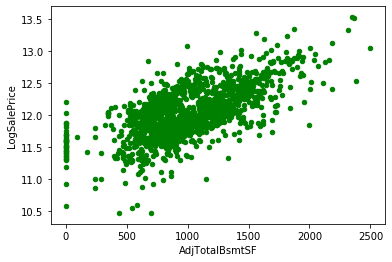

In [139]:
EDA_numeric(df, "AdjTotalBsmtSF")

# Variable 83 AdjTotalBath

Number of missing values:  0

Unique values and their frequencies:
2.0    443
2.6    293
1.0    228
3.0    172
3.6    144
1.6    129
3.2     14
2.2     12
4.0     11
4.6      6
2.8      2
4.2      2
4.8      1
2.4      1
5.2      1
6.0      1
Name: AdjTotalBath, dtype: int64

Mean LogSalePrice in different groups of AdjTotalBath


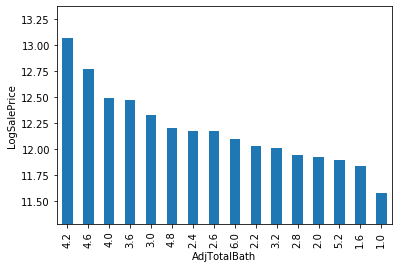

In [160]:
EDA_categorical(df, "AdjTotalBath")

# Variable 83 LogSalePrice

Number of missing values:  0

Statistic summary:
count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: LogSalePrice, dtype: float64

Number of outliers that is removed:0

Correlation with LogSalePrice before and after removing outliers are: 1.00 and 1.00, respectively.


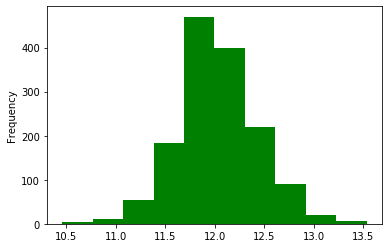

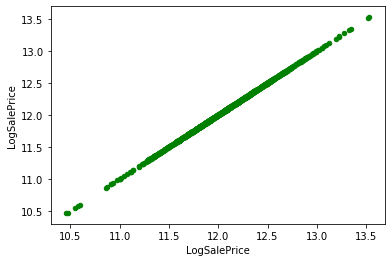

In [141]:
EDA_numeric(df, "LogSalePrice")